In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
import math

In [2]:
csv_list = []
resources = [1, 2, 4, 8]

time_taken = []
tput = []

for i in resources:
    csv_list.append(
        pd.read_csv(
            f"cluster_logs/{i}+{i}_image_inference_s3_batch_128_100pct.csv"
        )
    )

for csv_file in csv_list:
    time_taken.append(csv_file.iloc[-1]["time_from_start"])
    tput.append(csv_file.iloc[-1]["number_of_rows_finished"] / csv_file.iloc[-1]["time_from_start"])

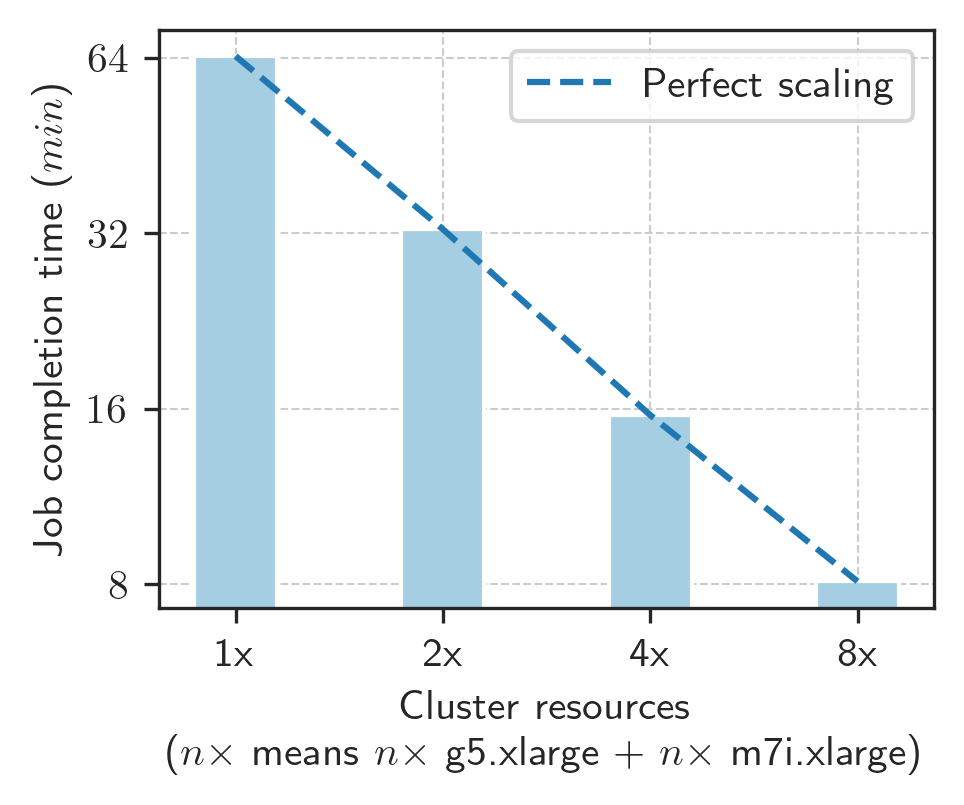

In [3]:
FIGRATIO = 3 / 4
FIGWIDTH = 3.335  # inches
FIGHEIGHT = FIGWIDTH * FIGRATIO
FIGSIZE = (FIGWIDTH, FIGHEIGHT)
BIG_SIZE = 10

resources_idx = np.arange(len(resources))
time_taken_hours = [t / 60 for t in time_taken]

COLORS = sns.color_palette("Paired")
sns.set_style("ticks")
sns.set_palette(COLORS)

plt.rcParams.update(
    {
        "figure.figsize": FIGSIZE,
        "figure.dpi": 300,
        "text.usetex": True,
    }
)
plt.rc("font", size=BIG_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIG_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIG_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=BIG_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=BIG_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=BIG_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIG_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots()

bars = ax.bar(resources_idx, time_taken_hours, color=COLORS[0], width=0.4)

ax.plot(resources_idx, time_taken_hours, linestyle="--", color=COLORS[1], label="Perfect scaling")

ax.set_xlabel("Cluster resources\n($n\\times$ means $n\\times$ g5.xlarge + $n\\times$ m7i.xlarge)")
ax.set_ylabel("Job completion time ($min$)")

ax.set_yscale("log")
ax.yaxis.set_minor_locator(ticker.NullLocator())
y_ticks = [
    2**i
    for i in range(
        int(math.log(min(time_taken_hours), 2)), int(math.log(max(time_taken_hours), 2)) + 1
    )
]
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"${int(y)}$" for y in y_ticks])
ax.set_xticks(resources_idx, [f"{x}x" for x in resources])

ax.grid(True, which="both", linestyle="--", linewidth=0.5)

ax.legend()
plt.savefig("image-scaling.pdf", bbox_inches="tight")

In [4]:
BATCH_SIZE = 128
DATA_PERCENTAGE = 100
COMPUTE = "1+1"
s3_0_1 = pd.read_csv(
    f"logs/csv/single_image_inference_s3_map_batches_{BATCH_SIZE}_{DATA_PERCENTAGE}pct.csv"
)

s3_1_1 = pd.read_csv(
    f"cluster_logs/{COMPUTE}_image_inference_s3_batch_{BATCH_SIZE}_{DATA_PERCENTAGE}pct.csv"
)

In [5]:
def process_single(data, resample="50s"):
    data = data.copy()
    data["time_from_start"] = pd.to_timedelta(data["time_from_start"], unit="s")
    data.set_index("time_from_start", inplace=True)
    avg_tput = np.mean(data["batch_throughput"])
    # tput_resampled = data['tput'].resample(resample).bfill()
    tput_resampled = data["batch_throughput"].resample(resample).mean().ffill()
    idx = [str(item) for item in tput_resampled.index.to_pytimedelta()]
    return idx, tput_resampled.values, avg_tput


def process_11(data, resample="50s"):
    data = data.copy()
    data["time_from_start"] = pd.to_timedelta(data["time_from_start"], unit="s")
    data.set_index("time_from_start", inplace=True)
    data["tput"] = data["number_of_rows_finished"].diff() / data.index.total_seconds().diff()
    data["tput"] = data["tput"].fillna(0)
    avg_tput = np.mean(data["tput"])
    # tput_resampled = data['tput'].resample(resample).bfill()
    tput_resampled = data["tput"].resample(resample).mean().ffill()
    idx = [str(item) for item in tput_resampled.index.to_pytimedelta()]
    return idx, tput_resampled.values, avg_tput

In [6]:
idx_s3_0_1, values_s3_0_1, avg_single = process_single(s3_0_1)
print("Single node avg tput: ", avg_single)

idx_s3_1_1, values_s3_1_1, avg_s3 = process_11(s3_1_1)
print("1+1 avg tput: ", avg_s3)

Single node avg tput:  342.6955584088864
1+1 avg tput:  403.7154585356676


In [7]:
flink_data = pd.read_csv("cluster_logs/flink_inference.csv")
idx_flink, values_flink, avg_flink = process_single(flink_data)
print("Flink avg tput: ", avg_flink)

Flink avg tput:  43.87296198548095


In [89]:
spark_data = pd.read_csv("cluster_logs/spark_inference.csv")
idx_spark, values_spark, avg_spark = process_single(spark_data, resample="150s")
print("Spark avg tput: ", avg_spark)

Spark avg tput:  104.41778460130382


In [90]:
theoretical_s3 = np.mean(s3_0_1["batch_inference_throughput"])
print("S3 avg theoretical: ", theoretical_s3)

S3 avg theoretical:  438.50079871784334


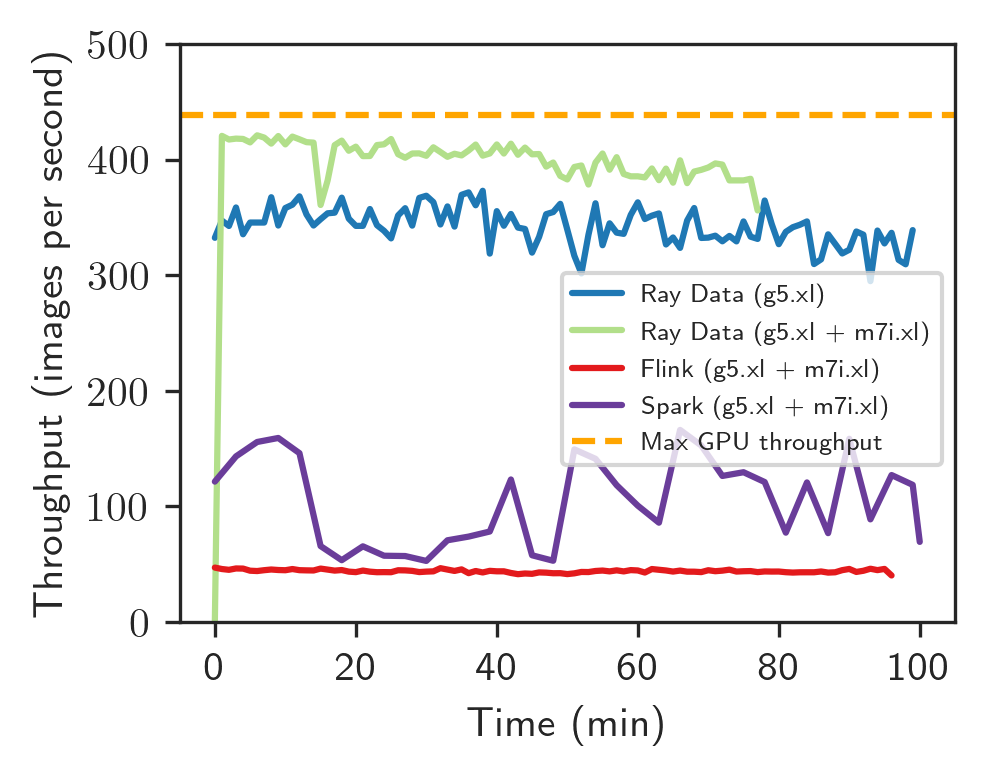

In [93]:
FIGRATIO = 3 / 4
FIGWIDTH = 3.335  # inches
FIGHEIGHT = FIGWIDTH * FIGRATIO
FIGSIZE = (FIGWIDTH, FIGHEIGHT)
BIG_SIZE = 10
COLORS = sns.color_palette("Paired")
sns.set_style("ticks")
sns.set_palette(COLORS)

plt.rcParams.update(
    {
        "figure.figsize": FIGSIZE,
        "figure.dpi": 300,
        "text.usetex": True,
    }
)
plt.rc("font", size=BIG_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIG_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIG_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=BIG_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=BIG_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=BIG_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIG_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots()

ax.plot(idx_s3_0_1, values_s3_0_1, label="Ray Data (g5.xl)", color=COLORS[1])
ax.plot(idx_s3_1_1, values_s3_1_1, label="Ray Data (g5.xl + m7i.xl)", color=COLORS[2])
ax.plot(idx_flink, values_flink, label="Flink (g5.xl + m7i.xl)", color=COLORS[5])
ax.plot(idx_spark, values_spark, label="Spark (g5.xl + m7i.xl)", color=COLORS[9])


ax.axhline(y=theoretical_s3, color="orange", linestyle="--", label="Max GPU throughput")

plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

plt.xticks([0, 20, 40, 60, 80, 100])
plt.gca().set_xticklabels(["0", "20", "40", "60", "80", "100"])

plt.xlabel("Time (min)")
plt.ylabel("Throughput (images per second)")
plt.ylim(0, 500)
plt.legend(fontsize=6, loc="lower right", bbox_to_anchor=(1, 0.25))
plt.savefig("image-tput.pdf", bbox_inches="tight")